In [1]:
import os
os.chdir("../")

In [66]:
from pathlib import Path
from dataclasses import dataclass

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    load_file_path: Path
    test_data_save: Path
    model_save: Path


In [67]:
from PhishingDomainDetection.constants import CONFIG_FILE_PATH, PARAMS_FILE_APTH
from PhishingDomainDetection.utils import read_yaml_file, create_directories
from PhishingDomainDetection.entity import DataIngestionConfig

In [69]:
class ConfigurationManager:
    def __init__(self, config_file_path=CONFIG_FILE_PATH, params_file_path=PARAMS_FILE_APTH):
        self.config = read_yaml_file(config_file_path)
        self.params = read_yaml_file(params_file_path)
        create_directories([self.config.artifacts_root])

    def get_data_load_for_training(self):
        self.data_load_config = self.config.data_preprocessing
        self.root_dir = self.data_load_config.root_dir
        self.file_dir = self.data_load_config.local_file
        self.file_path = os.path.join(self.root_dir, self.file_dir)
        return self.file_path
       

    def get_training_config(self) -> TrainingConfig:
        config = self.config.training
        

        create_directories([config.root_dir])

        training_config = TrainingConfig(
            root_dir=Path(config.root_dir),
            load_file_path=Path(self.get_data_load_for_training()),
            test_data_save=Path(config.test_data_save),
            model_save=Path(config.model_save)
        )

        return training_config

In [74]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split      
from sklearn.preprocessing import StandardScaler  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

In [75]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def load_data(self):
        data_path = self.config.load_file_path
        self.df = pd.read_csv(data_path)

    def spliting_data(self):
        self.train, test = train_test_split(self.df, test_size=0.3, random_state=33)
        training_root_dir = self.config.root_dir
        local_file_dir = self.config.test_data_save
        raw_local_dir_path = os.path.join(training_root_dir, local_file_dir)
        test.to_csv(raw_local_dir_path, index=False)

    def model_training(self):
        x = self.train.drop("phishing", axis=1)
        y = self.train['phishing']
        
        self.random_forest = RandomForestClassifier(max_depth=18, max_features='sqrt', min_samples_leaf=2, n_estimators=200)
        self.random_forest.fit(x, y)

    def save_model(self):
        training_root_dir = self.config.root_dir
        model_file_dir = self.config.model_save

        raw_model_file_path = os.path.join(training_root_dir, model_file_dir)
        joblib.dump(self.random_forest, raw_model_file_path)




In [76]:
config = ConfigurationManager()
training_config = config.get_training_config()
training = Training(config=training_config)
training.load_data()
training.spliting_data()
training.model_training()
training.save_model()

[2023-02-13 12:15:51,478: INFO common]: yaml file configs\config.yaml load  successfully
[2023-02-13 12:15:51,487: INFO common]: yaml file params.yaml load  successfully
[2023-02-13 12:15:51,489: INFO common]: created directory at artifacts
[2023-02-13 12:15:51,492: INFO common]: created directory at artifacts/training


In [44]:
df = pd.read_csv("artifacts/data_preprocessing/preprocess_data.csv")
df.shape

(116000, 25)

In [57]:
train, test = train_test_split(df, test_size=0.3, random_state=33)

In [73]:
test.shape

(34800, 25)

In [58]:
x = train.drop("phishing", axis=1)
y = train['phishing']

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [64]:
#Function to evaluate the models and output the accuracy score of the model
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="d")
    plt.title("confusion Matrix")
    plt.xlabel("Predict Label")
    plt.ylabel("True Label")
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy = {accuracy}")
#   print(f"F1 score = {f1_score(y_test, y_pred)}")
    print(f"classification report is =\n {classification_report(y_test, y_pred)}")

In [60]:
random_forest = RandomForestClassifier(max_depth=18, max_features='sqrt', min_samples_leaf=2, n_estimators=200)
random_forest.fit(x, y)


RandomForestClassifier(max_depth=18, min_samples_leaf=2, n_estimators=200)

In [61]:
random_forest.score(x, y)

0.9857635467980296

In [62]:
x_test = test.drop('phishing', axis=1)
y_test = test['phishing']

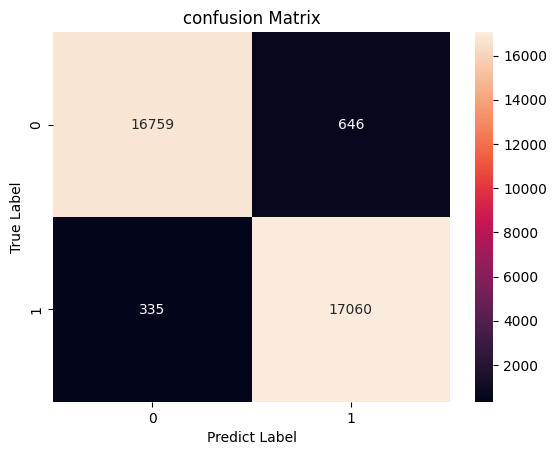

accuracy = 0.9718103448275862
classification report is =
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     17405
           1       0.96      0.98      0.97     17395

    accuracy                           0.97     34800
   macro avg       0.97      0.97      0.97     34800
weighted avg       0.97      0.97      0.97     34800



In [65]:
evaluate(random_forest, x_test, y_test)

In [77]:
m = joblib.load("artifacts/training/model.pkl")

In [79]:
y_pred2 = m.predict(x_test)

In [81]:
accuracy_score(y_test, y_pred2)

0.971867816091954